<a href="https://colab.research.google.com/github/asishpattnaik1/CE888/blob/main/Final_Project/TweetEvalClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import important libraries

In [186]:
import pandas as pd
import numpy as np
import urllib.request
import csv
import matplotlib.pyplot as plt

In [187]:
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

In [188]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

My chosen datasets are: **Offensive language identification** , **Hate speech detection** and **Sentiment Analysis.**

Loading Hate Datasets 

In [189]:
#loading Hate speech data
#Loading Train dataset
hate_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_train_text.columns= ["tweet_text"]
hate_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt",encoding='utf-8',sep="\n", header=None)
hate_train_label.columns= ["tweet_label"]

# Loading Validation dataset
hate_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_val_text.columns= ["tweet_text"]
hate_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_val_label.columns= ["tweet_label"]

# Loading Test dataset
hate_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_text.columns= ["tweet_text"]
hate_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_test_label.columns= ["tweet_label"]

# Loading Map
hate_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt",encoding='utf-8',sep="\t", header=None)
hate_map.columns= ["tweet_label","isHate"]


Loading Offensive Datasets

In [190]:
#loading offensive data
#Loading Train dataset
off_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt",encoding='utf-8',sep="\t", header=None)
off_train_text.columns= ["tweet_text"]
off_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt",encoding='utf-8',sep="\t", header=None)
off_train_label.columns= ["tweet_label"]

# Loading Validation dataset
off_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt",encoding='utf-8',sep="\t", header=None)
off_val_text.columns= ["tweet_text"]
off_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt",encoding='utf-8',sep="\t", header=None)
off_val_label.columns= ["tweet_label"]

# Loading Test dataset
off_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt",encoding='utf-8',sep="\t", header=None)
off_test_text.columns= ["tweet_text"]
off_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt",encoding='utf-8',sep="\t", header=None)
off_test_label.columns= ["tweet_label"]

#loading Map Dataset
off_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt",encoding='utf-8',sep="\t", header=None)
off_map.columns= ["tweet_label","offensive"]


Loading Sentiment Datasets

In [191]:
#loading Sentiment data
#Loading Train dataset
sen_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt",encoding='utf-8',sep="\t", header=None)
sen_train_text.columns= ["tweet_text"]
sen_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_train_label.columns= ["tweet_label"]

# Loading Validation dataset
sen_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt",encoding='utf-8',sep="\t", header=None)
sen_val_text.columns= ["tweet_text"]
sen_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_val_label.columns= ["tweet_label"]

# Loading Test dataset
sen_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt",encoding='utf-8',sep="\t", header=None)
sen_test_text.columns= ["tweet_text"]
sen_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_test_label.columns= ["tweet_label"]

#Loading Map dataset
sen_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt",encoding='utf-8',sep="\t", header=None)
sen_map.columns= ["tweet_label","sentiment"]



Common Pre-Processing of all the datasets

In [192]:
def clean_tweet(text):
  # "- Removing HTML tags
  #   - Removing punctuation
  #   - Lowering text
  #   "
  # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text


In [193]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [194]:
# Source of code: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# **Hate Detection**
## Preprocess

In [195]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_hate_train = pd.concat([hate_train_text,hate_train_label], axis=1)
df_hate_val = pd.concat([hate_val_text,hate_val_label], axis=1)
df_hate_test = pd.concat([hate_test_text,hate_test_label], axis=1)

In [196]:
hate_combo_train = pd.merge(df_hate_train,hate_map, on='tweet_label')
hate_combo_val = pd.merge(df_hate_val,hate_map, on='tweet_label')
hate_combo_test = pd.merge(df_hate_test,hate_map, on='tweet_label')

hate_train_val = pd.concat([hate_combo_train, hate_combo_val])

#checking total nan values/ empty rows
total =0
for n in pd.isna(hate_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

8

In [197]:
hate_train_val.dropna(inplace=True) #dropping the empty tweets, total 8, as they were included during the reading part
hate_combo_test.dropna(inplace=True)

In [198]:
train_hate = hate_train_val.copy()
train_hate['text_clean'] = train_hate['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [199]:
#removing workds like user and amp in clean tweets
train_hate['text_clean'] = train_hate['text_clean'].str.replace('user','')
train_hate['text_clean'] = train_hate['text_clean'].str.replace('amp','')
train_hate['text_clean'] = train_hate['text_clean'].str.replace('@','')
train_hate

,tweet_text,tweet_label,isHate,text_clean
0,@user nice new signage. Are you not concerned ...,0,not-hate,nice new signage. Are you not concerned by Be...
1,Hysterical woman like @user,0,not-hate,Hysterical woman like
2,Me flirting- So tell me about your father...,0,not-hate,Me flirting- So tell me about your father...
3,The Philippine Catholic bishops' work for migr...,0,not-hate,The Philippine Catholic bishops' work for migr...
4,When cuffin season is finally over,0,not-hate,When cuffin season is finally over
...,...,...,...,...
995,"shut the fuck up you know youre that bitch, wh...",1,hate,"shut the fuck up you know youre that bitch, wh..."
996,Where the fuck is your face scary hoe? Dont be...,1,hate,Where the fuck is your face scary hoe? Dont be...
997,Pass #MeritBased Immigration. Kill #ChainMigra...,1,hate,Pass #MeritBased Immigration. Kill #ChainMigra...
998,I usually dont hate people but I actually hate...,1,hate,I usually dont hate people but I actually hate...


In [200]:
# Hate tweet
print("Hate Tweet example :",hate_train_val[hate_train_val['isHate']=='hate']['tweet_text'].values[0])
#Not-Hate Tweet 
print("Not Hate Tweet example :",hate_train_val[hate_train_val['isHate']=='not-hate']['tweet_text'].values[0])

Hate Tweet example : A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎 
Not Hate Tweet example : @user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you… 


**Visualization**

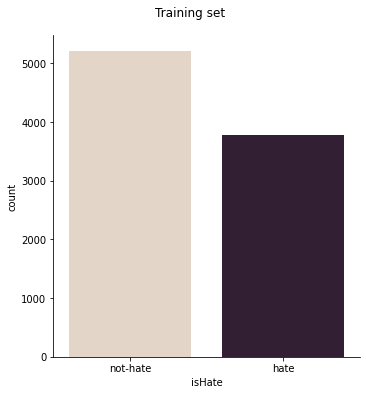

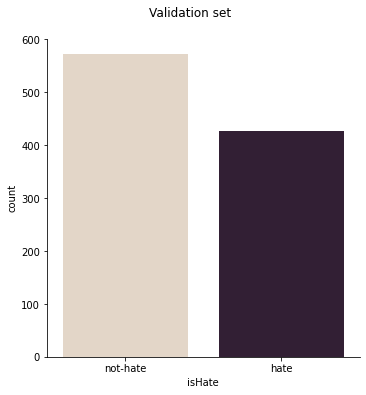

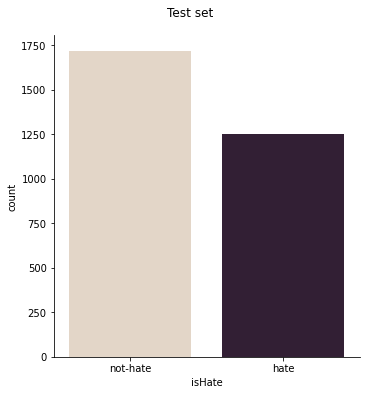

In [130]:
g = (sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("hate_train.png")
# files.download("hate_train.png")
plt.show()

v = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("hate_val.png")
# files.download("hate_val.png")
plt.show()

t = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("hate_test.png")
# files.download("hate_test.png")
plt.show()

In [131]:
#creating different datasets for different emotions for hate
from google.colab import files
hate_yes = train_hate[train_hate['isHate'] == 'hate']['text_clean']
hate_no = train_hate[train_hate['isHate'] == 'not-hate']['text_clean']

wordcloud

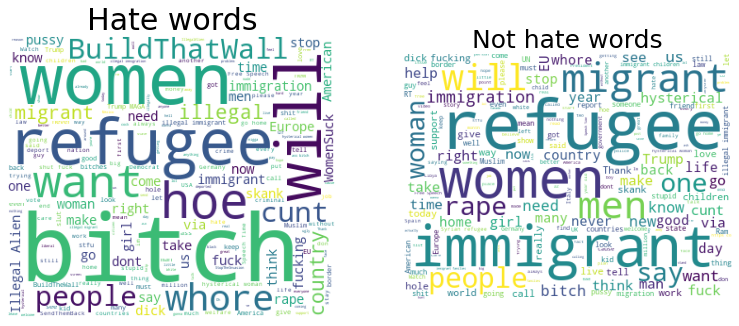

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[13, 13])

wordcloud1 = WordCloud( background_color='white',
                        width=350,
                        height=300).generate(" ".join(hate_yes))
#wordcloud1.to_file('hate_cloud.png')
#files.download('hate_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Hate words',fontsize=30);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=300).generate(" ".join(hate_no))
# wordcloud2.to_file('not_hate_cloud.png')
# files.download('not_hate_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not hate words',fontsize=25);

Top Hate and not hate word  Bar graph

In [133]:
top_hate_words = get_top_n_words(hate_yes)
top_nonHate_words = get_top_n_words(hate_no)


h1 = [x[0] for x in top_hate_words[:20]]
h2 = [x[1] for x in top_hate_words[:20]]

nh1 = [x[0] for x in top_nonHate_words[:20]]
nh2 = [x[1] for x in top_nonHate_words[:20]]

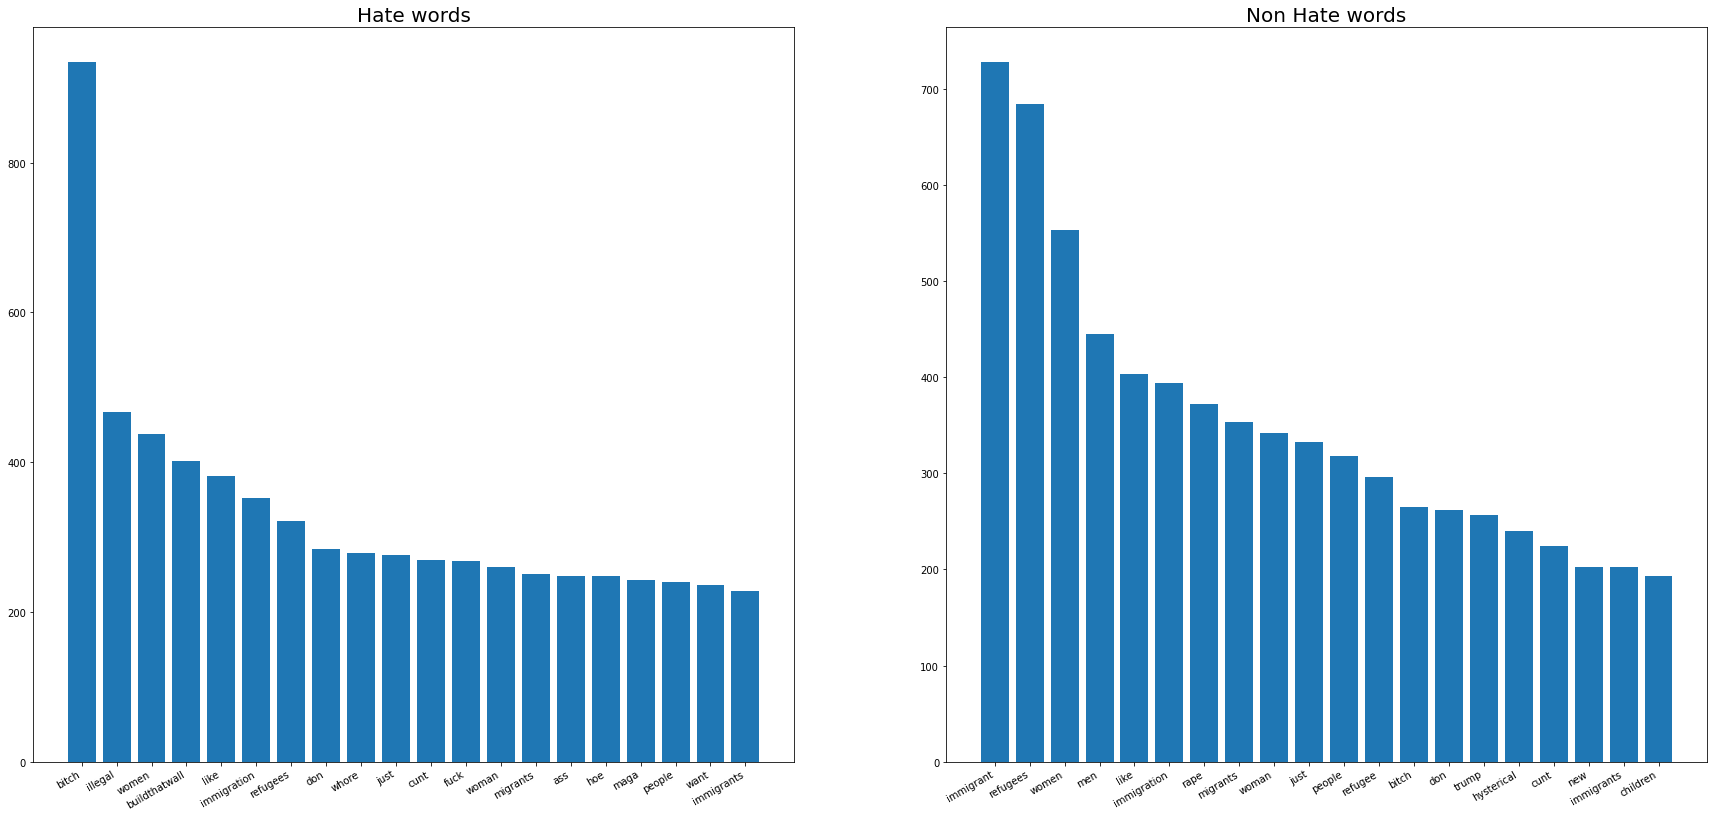

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(h1, h2)


ax1.set_title('Hate words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(nh1,nh2)
ax2.set_title('Non Hate words',fontsize=20);
fig.autofmt_xdate()

**Training the model and testing with macro averaged F1 score as evaluation metrics.**

In [201]:
vectorizer = CountVectorizer(stop_words="english",preprocessor=clean_tweet)
training_features = vectorizer.fit_transform(hate_train_val["tweet_text"])  # feature extraction of train and validation set
test_features = vectorizer.transform(hate_combo_test["tweet_text"]) #feature extraction of test set
model = LinearSVC()
model.fit(training_features,hate_train_val["isHate"])
y_pred = model.predict(test_features)

score = f1_score(hate_combo_test["isHate"], y_pred, average='macro')
print("F1 Score on hate detection dataset: {}".format(round(score*100,2)))

F1 Score on hate detection dataset: 49.35


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [136]:
# cleaning with basic clean funtion  and then vectorizing with TF-IDF  and bigrams for Hate dataset
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_tweet,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(hate_train_val["tweet_text"])    
test_features = vectorizer.transform(hate_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, hate_train_val["isHate"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(hate_combo_test["isHate"], y_pred,average='macro')

print("F1 score on the Hate dataset: {:.2f}".format(score*100))

F1 score on the Hate dataset: 39.62


In [137]:
# cleaning with proecss suggested by tweeteval  and then vectorizing with TF-IDF and bigrams hate dataset
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=preprocess,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(hate_train_val["tweet_text"])    
test_features = vectorizer.transform(hate_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, hate_train_val["isHate"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(hate_combo_test["isHate"], y_pred,average='macro')

print("F1 score on the Hate detection dataset: {:.2f}".format(score*100))

F1 score on the Hate detection dataset: 41.38


In [138]:
# cleaning with proecss suggested by tweeteval  and then vectorizing with countvectorizer and bigrams hate dataset
vectorizer = CountVectorizer(#stop_words="english",
                             preprocessor=preprocess,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(hate_train_val["tweet_text"])    
test_features = vectorizer.transform(hate_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, hate_train_val["isHate"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(hate_combo_test["isHate"], y_pred,average='macro')

print("F1 score on the Hate detection dataset: {:.2f}".format(score*100))

F1 score on the Hate detection dataset: 48.67


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [139]:

hate_combo_test[['tweet_text','isHate']]

,tweet_text,isHate
0,"@user , you are correct that Reid certainly is...",not-hate
1,@user @user @user Always #NoDACA.I AM BORN IN ...,not-hate
2,@user friends ? that's my BLOOD brother bitch ...,not-hate
3,@user @user Like he ever kept out any threats....,not-hate
4,@user @user They can scrim whoever they fuckin...,not-hate
...,...,...
2965,"""GET this WORSE THAN SCUM OUT OF OUR COUNTRY! ...",hate
2966,Let this hoe touch this kid I swear to fucking...,hate
2967,@user @user That's what happens when illegal a...,hate
2968,@user StopImmigration,hate


In [143]:
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = hate_train_val[['tweet_text','isHate']]
test_data = hate_combo_test[['tweet_text','isHate']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [144]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Training the model and testing the model

In [157]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [162]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 48, 128)           256000    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 48, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [166]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['isHate']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['isHate']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
79/79 [==============================] - 35s 445ms/step - loss: 0.0562 - accuracy: 0.9779 - f1_m: 0.9781 - precision_m: 0.9781 - recall_m: 0.9781
Epoch 2/10
79/79 [==============================] - 36s 453ms/step - loss: 0.0545 - accuracy: 0.9798 - f1_m: 0.9785 - precision_m: 0.9785 - recall_m: 0.9785
Epoch 3/10
79/79 [==============================] - 35s 440ms/step - loss: 0.0550 - accuracy: 0.9805 - f1_m: 0.9807 - precision_m: 0.9807 - recall_m: 0.9807
Epoch 4/10
79/79 [==============================] - 34s 437ms/step - loss: 0.0527 - accuracy: 0.9804 - f1_m: 0.9806 - precision_m: 0.9806 - recall_m: 0.9806
Epoch 5/10
79/79 [==============================] - 34s 433ms/step - loss: 0.0389 - accuracy: 0.9859 - f1_m: 0.9861 - precision_m: 0.9861 - recall_m: 0.9861
Epoch 6/10
79/79 [==============================] - 34s 433ms/step - loss: 0.0472 - accuracy: 0.9820 - f1_m: 0.9822 - precision_m: 0.9822 - recall_m: 0.9822
Epoch 7/10
79/79 [==============================] - 35s 44

**Best F1 score is generated with countvectorizer, basic cleaning and without bigrams**

#**Offensive Dataset**
## Preprocess

In [202]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_off_train = pd.concat([off_train_text,off_train_label], axis=1)
df_off_val = pd.concat([off_val_text,off_val_label], axis=1)
df_off_test = pd.concat([off_test_text,off_test_label], axis=1)

In [203]:
off_combo_train = pd.merge(df_off_train,off_map, on='tweet_label')
off_combo_val = pd.merge(df_off_val,off_map, on='tweet_label')
off_combo_test = pd.merge(df_off_test,off_map, on='tweet_label')

In [204]:
off_train_val = pd.concat([off_combo_train,off_combo_val])

In [205]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(off_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

0

In [206]:
train_off = off_train_val.copy()
train_off['text_clean'] = train_off['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [207]:
#removing workds like user and amp in clean tweets
train_off['text_clean'] = train_off['text_clean'].str.replace('user','')
train_off['text_clean'] = train_off['text_clean'].str.replace('amp','')
train_off['text_clean'] = train_off['text_clean'].str.replace('@','')
train_off

,tweet_text,tweet_label,offensive,text_clean
0,@user Bono... who cares. Soon people will unde...,0,not-offensive,Bono... who cares. Soon people will understan...
1,@user Get him some line help. He is gonna be j...,0,not-offensive,Get him some line help. He is gonna be just f...
2,@user @user She is great. Hi Fiona!,0,not-offensive,She is great. Hi Fiona!
3,@user @user @user @user @user @user @user @use...,0,not-offensive,"This is the VetsResistSquadron""..."
4,@user @user Lol. Except he’s the most successf...,0,not-offensive,Lol. Except he’s the most successful preside...
...,...,...,...,...
1319,@user @user @user Weak argument considering -...,1,offensive,Weak argument considering -GOP congressmen...
1320,@user Stop saying this shit you are not going ...,1,offensive,Stop saying this shit you are not going to do...
1321,@user @user @user @user @user Sorry to break i...,1,offensive,Sorry to break it to you but the god of t...
1322,. she. is the most powerful woman on this eart...,1,offensive,. she. is the most powerful woman on this eart...


In [208]:
# offensive tweet
print("Offensive Tweet example :",off_train_val[off_train_val['offensive']=='offensive']['tweet_text'].values[0])
#Not-offensive Tweet 
print("Non offensive Tweet example :",off_train_val[off_train_val['offensive']=='not-offensive']['tweet_text'].values[0])


Offensive Tweet example : @user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 
Non offensive Tweet example : @user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen. 


Visualization

In [209]:
#creating different datasets for different classes
off_yes = train_off[train_off['offensive'] == 'offensive']['text_clean']
off_no = train_off[train_off['offensive'] == 'not-offensive']['text_clean']


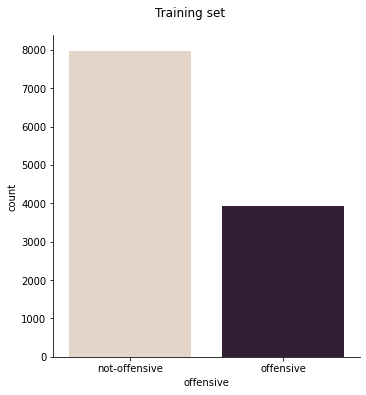

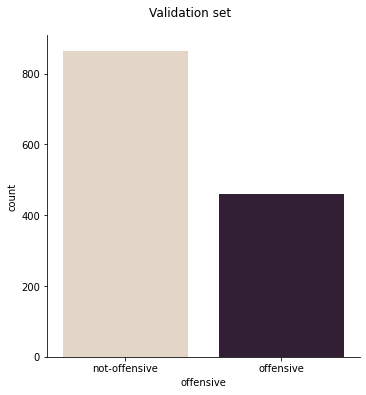

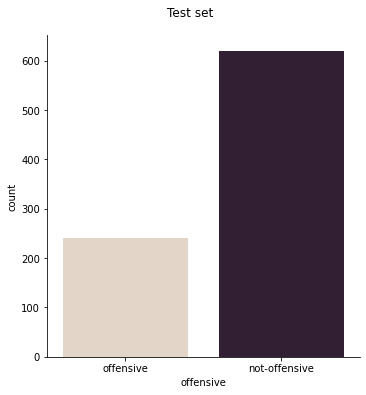

In [210]:
g = (sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("off_train.png")
# files.download("off_train.png")
plt.show()

v = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("off_val.png")
# files.download("off_val.png")
plt.show()

t = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("off_test.png")
#files.download("off_test.png")
plt.show()


wordcloud

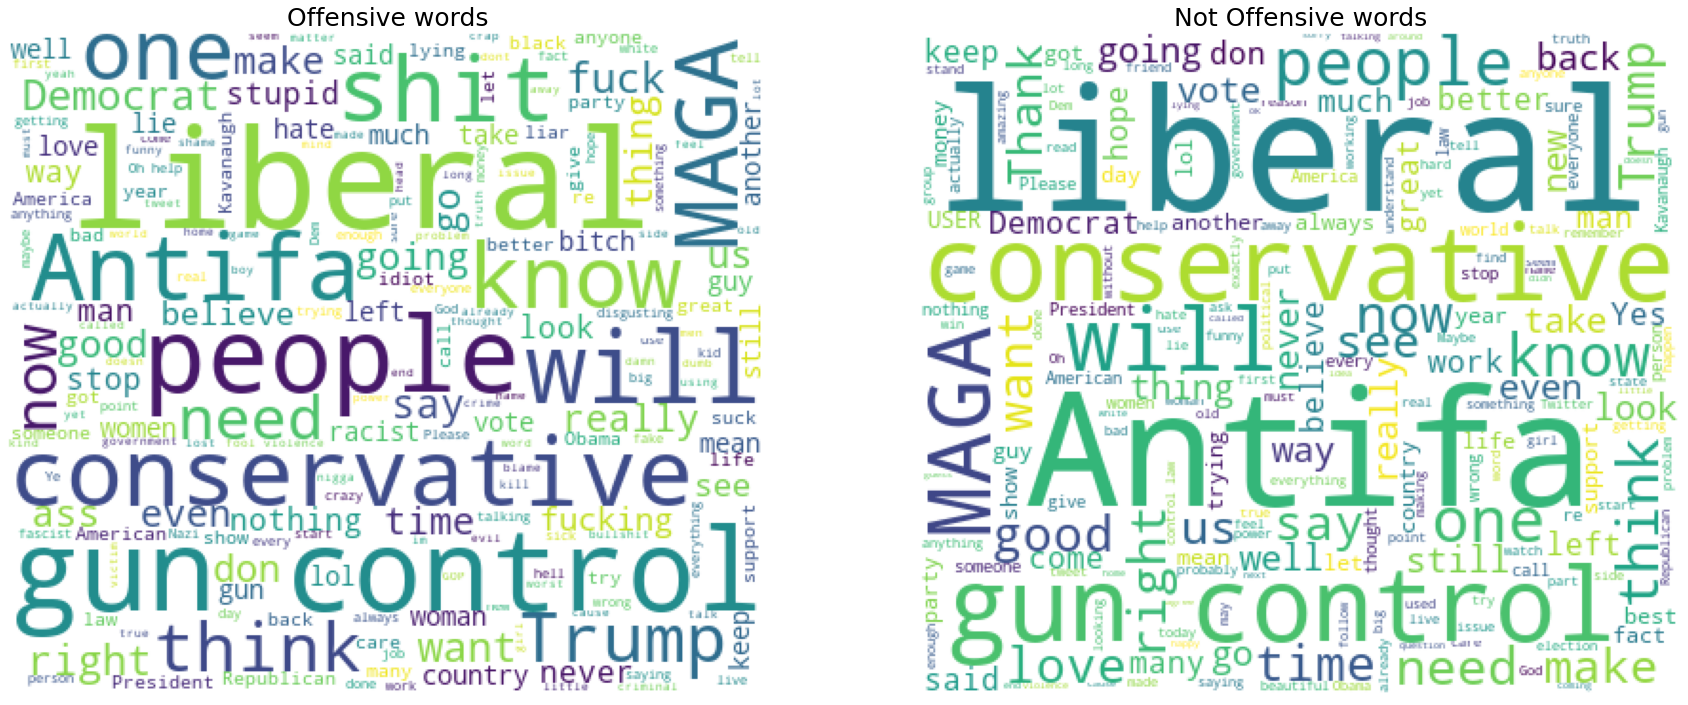

In [211]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(off_yes))
#wordcloud1.to_file('off_cloud.png')
#files.download('off_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Offensive words',fontsize=25);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(off_no))
# wordcloud2.to_file('non_off_cloud.png')
# files.download('non_off_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not Offensive words',fontsize=25);

 

In [212]:
# getting top 20 words in both sets of  Offensive dataset
top_offensive_words = get_top_n_words(off_yes)
top_nonOff_words = get_top_n_words(off_no)


of1 = [x[0] for x in top_offensive_words[:20]]
of2 = [x[1] for x in top_offensive_words[:20]]

no1 = [x[0] for x in top_nonOff_words[:20]]
no2 = [x[1] for x in top_nonOff_words[:20]]



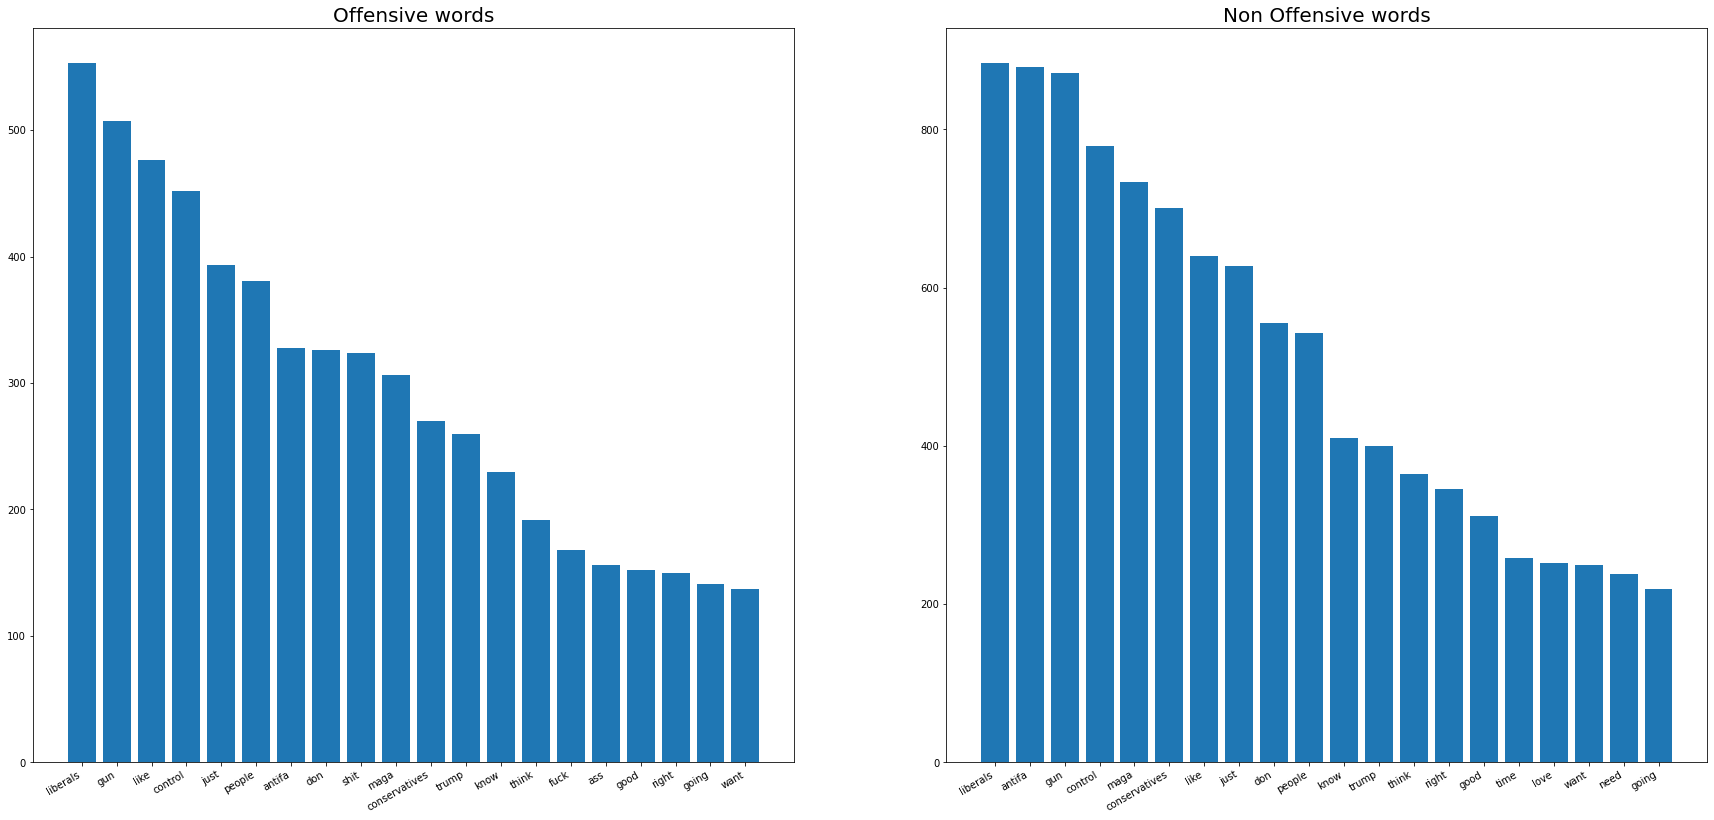

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(of1,of2)


ax1.set_title('Offensive words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(no1,no2)
ax2.set_title('Non Offensive words',fontsize=20);
fig.autofmt_xdate()





**Training the model and testing with macro averaged F1 score as evaluation metrics.**

In [214]:
vectorizer = CountVectorizer(stop_words="english",preprocessor=clean_tweet)

training_features = vectorizer.fit_transform(off_train_val["tweet_text"])  # feature extraction of train and validation set
test_features = vectorizer.transform(off_combo_test["tweet_text"]) #feature extraction of test set

model = LinearSVC()
model.fit(training_features,off_train_val["offensive"])
y_pred = model.predict(test_features)

score = f1_score(off_combo_test["offensive"], y_pred, average='macro')
print("F1 Score on offensive language dataset is: {}".format(round(score*100,2)))

F1 Score on offensive language dataset is: 70.75


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [215]:
# cleaning with basic clean funtion  and then vectorizing with TF-IDF and bigrams for Offensive dataset
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_tweet,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(off_train_val["tweet_text"])    
test_features = vectorizer.transform(off_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, off_train_val["offensive"])
y_pred = model.predict(test_features)

# Evaluation 
score = f1_score(off_combo_test["offensive"], y_pred,average='macro')

print("F1 score on the offensive language dataset is: {:.2f}".format(score*100))

F1 score on the offensive language dataset is: 74.00


In [216]:
# cleaning with  clean funtion given by tweeteval  and then vectorizing with countvectorizer and bigrams for Offensive dataset
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=preprocess,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(off_train_val["tweet_text"])    
test_features = vectorizer.transform(off_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, off_train_val["offensive"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(off_combo_test["offensive"], y_pred,average='macro')

print("F1 score on the offensive language dataset is: {:.2f}".format(score*100))

F1 score on the offensive language dataset is: 71.84


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [217]:
# cleaning with clean funtion given by tweeteval  and then vectorizing with TF-IDF and bigrams for Offensive dataset
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=preprocess,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(off_train_val["tweet_text"])    
test_features = vectorizer.transform(off_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, off_train_val["offensive"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(off_combo_test["offensive"], y_pred,average='macro')

print("F1 score on the offensive language dataset is: {:.2f}".format(score*100))

F1 score on the offensive language dataset is: 73.17


In [218]:
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = off_train_val[['tweet_text','offensive']]
test_data = off_combo_test[['tweet_text','offensive']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [219]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Model Training and testing of model

In [220]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 47, 128)           256000    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 47, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [221]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['offensive']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['offensive']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
104/104 [==============================] - 45s 400ms/step - loss: 0.6317 - accuracy: 0.6619 - f1_m: 0.6619 - precision_m: 0.6619 - recall_m: 0.6619
Epoch 2/10
104/104 [==============================] - 41s 399ms/step - loss: 0.4790 - accuracy: 0.7766 - f1_m: 0.7766 - precision_m: 0.7766 - recall_m: 0.7766
Epoch 3/10
104/104 [==============================] - 42s 401ms/step - loss: 0.4363 - accuracy: 0.8068 - f1_m: 0.8068 - precision_m: 0.8068 - recall_m: 0.8068
Epoch 4/10
104/104 [==============================] - 42s 403ms/step - loss: 0.4093 - accuracy: 0.8153 - f1_m: 0.8153 - precision_m: 0.8153 - recall_m: 0.8153
Epoch 5/10
104/104 [==============================] - 42s 399ms/step - loss: 0.3943 - accuracy: 0.8261 - f1_m: 0.8261 - precision_m: 0.8261 - recall_m: 0.8261
Epoch 6/10
104/104 [==============================] - 41s 399ms/step - loss: 0.3715 - accuracy: 0.8393 - f1_m: 0.8393 - precision_m: 0.8393 - recall_m: 0.8393
Epoch 7/10
104/104 [==========================

**cleaning with basic clean funtion and then vectorizing with TF-IDF and bigrams for Offensive dataset gives best F1 score**

# **Sentiment Dataset**
## Preprocess

In [222]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_sen_train = pd.concat([sen_train_text,sen_train_label], axis=1)
df_sen_val = pd.concat([sen_val_text,sen_val_label], axis=1)
df_sen_test = pd.concat([sen_test_text,sen_test_label], axis=1)

In [223]:
sen_combo_train = pd.merge(df_sen_train,sen_map, on='tweet_label')
sen_combo_val = pd.merge(df_sen_val,sen_map, on='tweet_label')
sen_combo_test = pd.merge(df_sen_test,sen_map, on='tweet_label')

In [224]:
sen_train_val = pd.concat([sen_combo_train,sen_combo_val])

In [225]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(sen_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

9619

In [226]:
sen_train_val.dropna(inplace=True) #dropping the empty tweets, total 9619, as they were included during the reading part
sen_combo_test.dropna(inplace=True)

In [227]:
train_sen = sen_train_val.copy()
train_sen['text_clean'] = train_sen['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [228]:
#removing workds like user,@ and amp in clean tweets
train_sen['text_clean'] = train_sen['text_clean'].str.replace('user','')
train_sen['text_clean'] = train_sen['text_clean'].str.replace('amp','')
train_sen['text_clean'] = train_sen['text_clean'].str.replace('@','')
train_sen['text_clean'] = train_sen['text_clean'].str.replace('@user','')
train_sen

,tweet_text,tweet_label,sentiment,text_clean
0,QT @user In the original draft of the 7th book...,2,positive,"QT In the original draft of the 7th book, Rem..."
1,@user Alciato: Bee will invest 150 million in ...,2,positive,Alciato: Bee will invest 150 million in Janua...
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive,LIT MY MUM 'Kerry the louboutins I wonder how...
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",2,positive,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ..."
4,"This is the last Sunday w/o football .....,NFL...",2,positive,"This is the last Sunday w/o football .....,NFL..."
...,...,...,...,...
1941,According to Janet Jackson's long time produce...,0,negative,According to Janet Jackson's long time produce...
1942,Monday at Town Ballroom: RICHIE HAWTIN with LO...,0,negative,Monday at Town Ballroom: RICHIE HAWTIN with LO...
1943,Disappointed the Knicks vs Nets game got cance...,0,negative,Disappointed the Knicks vs Nets game got cance...
1944,"\""""@_eryflores: March 16 Luke Bryan is gonna a...",0,negative,"\""""_eryflores: March 16 Luke Bryan is gonna at..."


In [229]:
# negative tweet
print("negative Tweet example :",train_sen[train_sen['sentiment']=='negative']['tweet_text'].values[0])
#neutral Tweet 
print("neutral Tweet example :",train_sen[train_sen['sentiment']=='neutral']['tweet_text'].values[0])
#positive tweet
print("positive tweet example  :",train_sen[train_sen['sentiment']=='positive']['tweet_text'].values[0]) 

negative Tweet example : So disappointed in wwe summerslam! I want to see john cena wins his 16th title 
neutral Tweet example : Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ 
positive tweet example  : QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin 


In [230]:
train_sen['sentiment'].value_counts(normalize=True)

neutral     0.451337
positive    0.392436
negative    0.156227
Name: sentiment, dtype: float64

In [232]:
train_sen.head()

,tweet_text,tweet_label,sentiment,text_clean
0,QT @user In the original draft of the 7th book...,2,positive,"QT In the original draft of the 7th book, Rem..."
1,@user Alciato: Bee will invest 150 million in ...,2,positive,Alciato: Bee will invest 150 million in Janua...
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive,LIT MY MUM 'Kerry the louboutins I wonder how...
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",2,positive,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ..."
4,"This is the last Sunday w/o football .....,NFL...",2,positive,"This is the last Sunday w/o football .....,NFL..."


**Visualization**

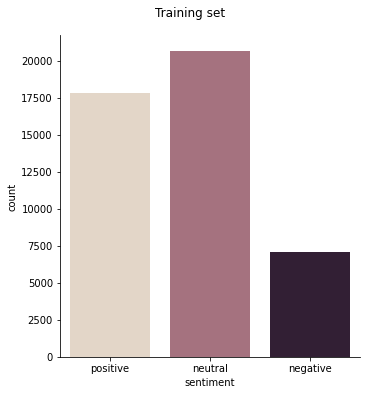

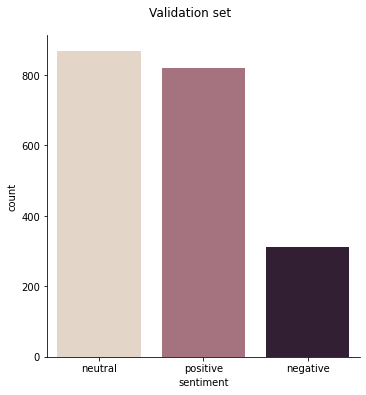

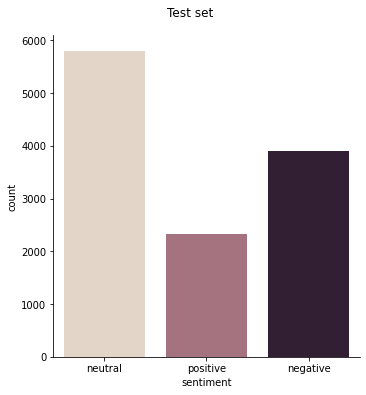

In [233]:
g = (sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_train))
g.fig.suptitle("Training set", y=1.05)
#g.savefig("sen_train1.png")
#files.download("emo_train1.png")
plt.show()

v = sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("sen_val.png")
#files.download("sen_val.png")
plt.show()

t = sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("sen_test.png")
# files.download("sen_test.png")

plt.show()



all the three datasets are similarly unbalanced.

In [234]:
#creating different datasets for different emotions
sen_negative = train_sen[train_sen['sentiment'] == 'negative']['text_clean']
sen_neutral = train_sen[train_sen['sentiment'] == 'neutral']['text_clean']
sen_positive = train_sen[train_sen['sentiment'] == 'positive']['text_clean']


In [240]:
# Source of code: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

wordcloud


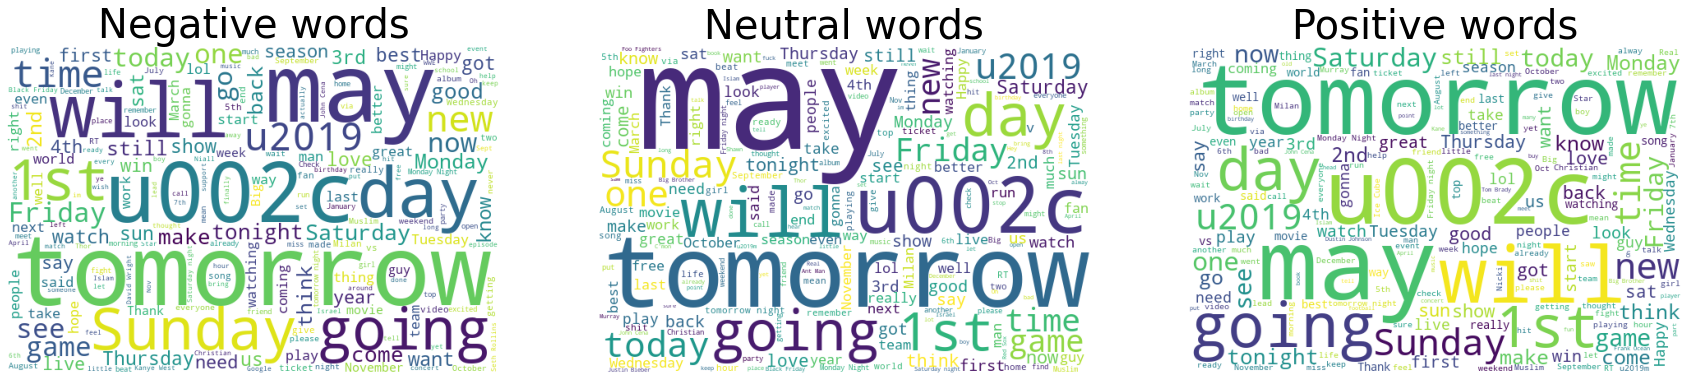

In [236]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_negative))
# wordcloud1.to_file('negative_cloud.png')
# files.download('negative_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Negative words',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_neutral))
# wordcloud2.to_file('neutral_cloud.png')
# files.download('neutral_cloud.png')

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Neutral words',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_positive))
# wordcloud3.to_file('positive_cloud.png')
# files.download('positive_cloud.png')

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive words',fontsize=40);

In [237]:
top_negative_words = get_top_n_words(sen_negative)
top_neutral_words = get_top_n_words(sen_neutral)
top_positive_words= get_top_n_words(sen_positive)


n1 = [x[0] for x in top_negative_words[:20]]
n2 = [x[1] for x in top_negative_words[:20]]

u1 = [x[0] for x in top_neutral_words[:20]]
u2 = [x[1] for x in top_neutral_words[:20]]

p1 = [x[0] for x in top_positive_words[:20]]
p2 = [x[1] for x in top_positive_words[:20]]


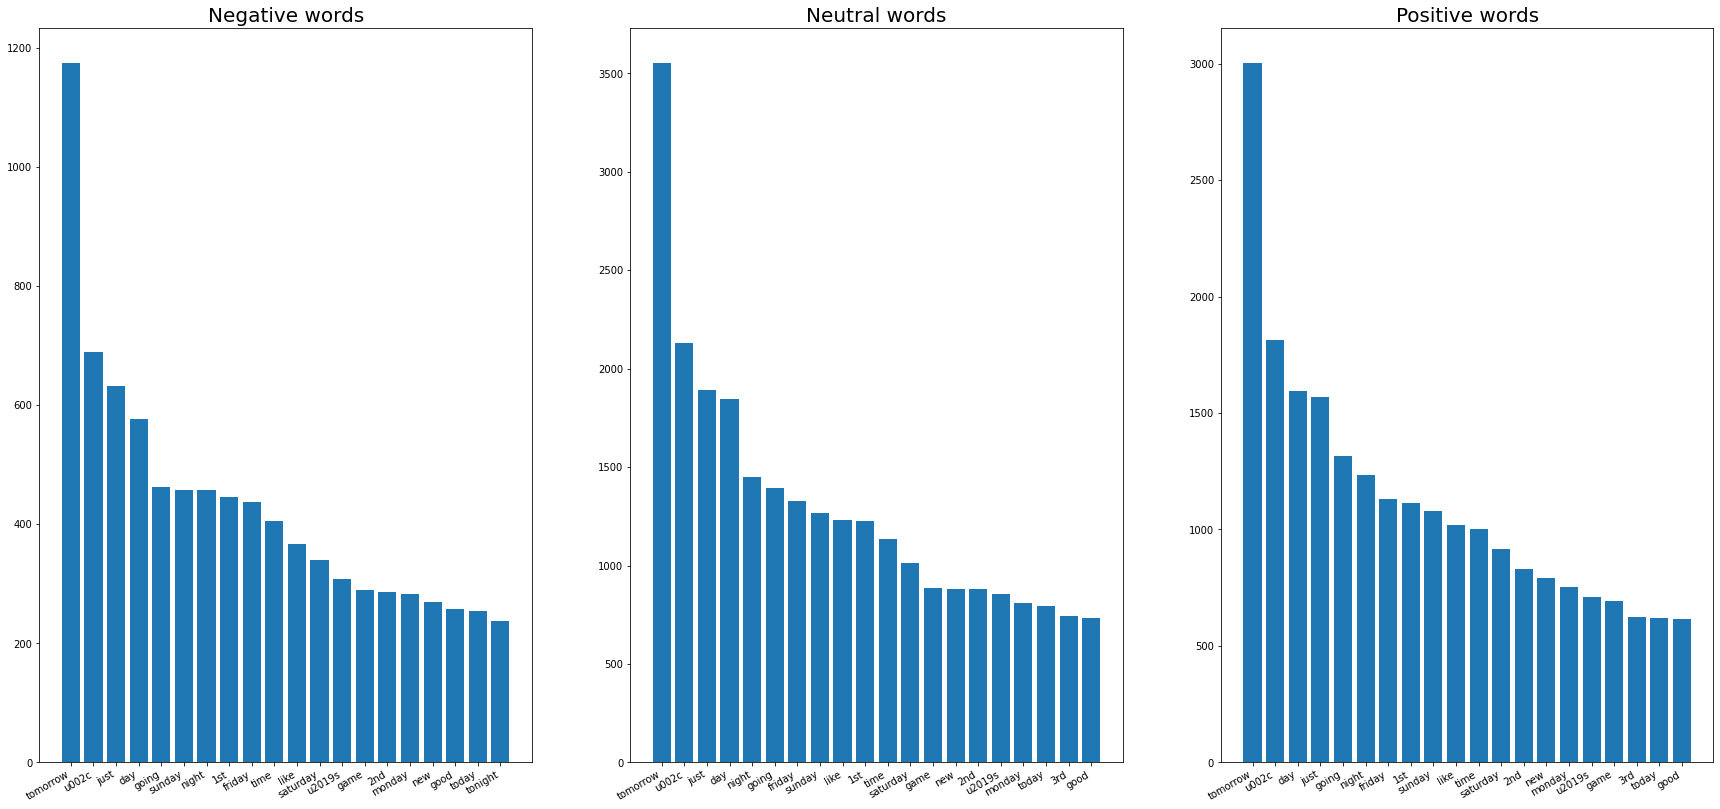

In [238]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=[30, 15])
ax1.bar(n1, n2)
ax1.set_title('Negative words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(u1,u2)
ax2.set_title('Neutral words',fontsize=20);
fig.autofmt_xdate()

ax3.bar(p1,p2)
ax3.set_title('Positive words',fontsize=20);
fig.autofmt_xdate()

**Training the model and testing with macro averaged F1 score as evaluation metrics.**

In [242]:

#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = sen_train_val[['tweet_text','sentiment']]
test_data = sen_combo_test[['tweet_text','sentiment']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [243]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Model Training and Model Testing

In [247]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 229, 128)          256000    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 229, 128)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 651,011
Trainable params: 651,011
Non-trainable params: 0
_________________________________________________________________


In [248]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['sentiment']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['sentiment']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
297/297 [==============================] - 570s 2s/step - loss: 1.0250 - accuracy: 0.4472 - f1_m: 0.0145 - precision_m: 0.1028 - recall_m: 0.0093
Epoch 2/10
297/297 [==============================] - 567s 2s/step - loss: 1.0066 - accuracy: 0.4635 - f1_m: 0.1048 - precision_m: 0.5002 - recall_m: 0.0632
Epoch 3/10
297/297 [==============================] - 569s 2s/step - loss: 0.9892 - accuracy: 0.4934 - f1_m: 0.2399 - precision_m: 0.5626 - recall_m: 0.1623
Epoch 4/10
297/297 [==============================] - 560s 2s/step - loss: 0.9708 - accuracy: 0.5031 - f1_m: 0.3480 - precision_m: 0.5793 - recall_m: 0.2529
Epoch 5/10
297/297 [==============================] - 562s 2s/step - loss: 0.9546 - accuracy: 0.5193 - f1_m: 0.3803 - precision_m: 0.5847 - recall_m: 0.2853
Epoch 6/10
297/297 [==============================] - 565s 2s/step - loss: 0.9407 - accuracy: 0.5307 - f1_m: 0.4158 - precision_m: 0.5919 - recall_m: 0.3219
Epoch 7/10
297/297 [==============================] - 562s

cleaning the data and then using Linear SVM for inital training and testing using  BOW vectorizer from Python with countvectorizer from scikitlearn.

In [241]:
vectorizer = CountVectorizer(stop_words="english",preprocessor=clean_tweet)

training_features = vectorizer.fit_transform(sen_train_val["tweet_text"]) 
test_features = vectorizer.transform(sen_combo_test["tweet_text"])
model = LinearSVC()
model.fit(training_features,sen_train_val["sentiment"])
y_pred = model.predict(test_features)

score = f1_score(sen_combo_test["sentiment"], y_pred, average='macro')
print("F1 Score on sentiment dataset is: {}".format(round(score*100,2)))

TypeError: ignored

Taking n-gram:

In [ ]:
# modeling with countvectorizer and bigrams
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_tweet,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(sen_train_val["tweet_text"])    
test_features = vectorizer.transform(sen_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, sen_train_val["sentiment"])
y_pred = model.predict(test_features)


# Evaluation
score = f1_score(sen_combo_test["sentiment"], y_pred,average='macro')

print("F1 score on the sentiment dataset is: {:.2f}".format(score*100))

F1 score on the sentiment dataset is: 28.06


checking TF-IDF vectorizer with bigram

In [ ]:
# modeling with TF-IDF and bigrams
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_tweet,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(sen_train_val["tweet_text"])    
test_features = vectorizer.transform(sen_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, sen_train_val["sentiment"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(sen_combo_test["sentiment"], y_pred,average='macro')

print("F1 score on the sentiment dataset is: {:.2f}".format(score*100))

F1 score on the sentiment dataset is: 28.25


In [ ]:
#cleaning with process suggested by tweeteval  and then vectorizing with countvectorizer with bigrams to train sentiment dataset by SVM

vectorizer = CountVectorizer(#stop_words="english",
                             preprocessor=preprocess,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(sen_train_val["tweet_text"])    
test_features = vectorizer.transform(sen_combo_test["tweet_text"])

# Training
model = LinearSVC()
model.fit(training_features, sen_train_val["sentiment"])
y_pred = model.predict(test_features)

# Evaluation
score = f1_score(sen_combo_test["sentiment"], y_pred,average='macro')

print("F1 score on the sentiment dataset is: {:.2f}".format(score*100))

F1 score on the sentiment dataset is: 28.95


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The F1 score is still not that good.